In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%cd -q ..

In [3]:
import lcpfn
import torch
import numpy as np
from matplotlib import pyplot as plt
import torch.nn as nn

print(torch.__version__)

/home/antonio14bernardes/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


1.11.0+cu102


# Training the LCPFN

In [ ]:
%pip install torch==1.11.0

In [ ]:
get_batch_func = lcpfn.create_get_batch_func(prior=lcpfn.sample_from_prior)

# Authors tried
# emsize ∈ [128, 256, 512]
# nlayers ∈ [3, 6, 12]
# nb_data ∈ [100k, 1M, 10M]
# steps_per_epoch is hardcoded to 100
# num_curves is currently 50000
# embedding size = 256
# attention heads = 2

result = lcpfn.train_lcpfn(get_batch_func=get_batch_func,
                          seq_len=100,
                         emsize=256,
                         nlayers=3,
                         num_borders=1000,
                         lr=0.001,
                         batch_size=500,
                         epochs=300)

transformer_model = result[2]



In [ ]:
model_save_path = "lcpfn/trained_models/"+"reproduction_model.pt"

In [ ]:
# Save the model

torch.save(transformer_model, model_save_path)

# Getting the lc data

In [ ]:


# Get the data for cutoff 10 inference
prior_10 = lcpfn.sample_from_prior(np.random)
curve_10, _ = prior_10()
x_10 = torch.arange(1, 101).unsqueeze(1)
y_10 = torch.from_numpy(curve_10).float().unsqueeze(1)
cutoff_10 = 10
data_10 = {'x': x_10, 'y': y_10, 'cutoff': cutoff_10}

# Get the data for cutoff 20 inference
prior_20 = lcpfn.sample_from_prior(np.random)
curve_20, _ = prior_20()
x_20 = torch.arange(1, 101).unsqueeze(1)
y_20 = torch.from_numpy(curve_20).float().unsqueeze(1)
cutoff_20 = 20
data_20 = {'x': x_20, 'y': y_20, 'cutoff': cutoff_20}

# Inference with LCPFN

In [ ]:
# Load trained model
lcpfn_model = lcpfn.LCPFN(model_save_path)

# Predictions for cutoff = 10
x = data_10['x']
y = data_10['y']
cutoff = data_10['cutoff']
predictions_10 = lcpfn_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])

# Predictions for cutoff = 20
x = data_20['x']
y = data_20['y']
cutoff = data_20['cutoff']
predictions_20 = lcpfn_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])





In [ ]:
# Plotting
plt.figure(figsize=(10, 5))

# Move x backward one unit
for i in range(len(x_10)):
  x_10[i] -= 1
  x_20[i] -= 1


# Plot target curves
plt.plot(x_10, y_10, "black", label="Target for Cutoff 10")
plt.plot(x_20, y_20, "grey", label="Target for Cutoff 20")

# Plot extrapolations
plt.plot(x_10[cutoff_10:], predictions_10[:, 1], "blue", label="Extrapolation for Cutoff 10")
plt.fill_between(x_10[cutoff_10:].flatten(), predictions_10[:, 0], predictions_10[:, 2], color="blue", alpha=0.2, label="90% CI for Cutoff 10")

plt.plot(x_20[cutoff_20:], predictions_20[:, 1], "green", label="Extrapolation for Cutoff 20")
plt.fill_between(x_20[cutoff_20:].flatten(), predictions_20[:, 0], predictions_20[:, 2], color="green", alpha=0.2, label="90% CI for Cutoff 20")

# Plot cutoff lines
plt.axvline(x=cutoff_10, color='blue', linestyle='--', linewidth=0.5, label='Cutoff at 10')
plt.axvline(x=cutoff_20, color='green', linestyle='--', linewidth=0.5, label='Cutoff at 20')

plt.ylim(0, 1)
plt.legend(loc="lower right")
plt.title("Model Extrapolation with Different Cutoffs")
plt.xlabel("X")
plt.ylabel("Y")

# Inference with MCMC

In [ ]:
# MCMC code does not work with the same version of pytorch as the LC-PFN code, so update torch version

%pip install torch --upgrade
%pip install gpytorch
%pip install botorch

In [ ]:
from lcpfn.priors.fast_gp_mix import get_model


def get_mcmc_model_variable_chains(x, y, hyperparameters, device, num_samples, warmup_steps, num_chains, obs=True):
    from pyro.infer.mcmc import NUTS, MCMC, HMC
    import pyro
    x = x.to(device)
    y = y.to(device)
    model, likelihood = get_model(x, y, hyperparameters, sample=False)
    model.to(device)


    def pyro_model(x, y):
        sampled_model = model.pyro_sample_from_prior()
        output = sampled_model.likelihood(sampled_model(x))
        if obs:
            return pyro.sample("obs", output, obs=y)

    nuts_kernel = NUTS(pyro_model)
    mcmc_run = MCMC(nuts_kernel, num_samples=num_samples, warmup_steps=warmup_steps, num_chains=num_chains)#num_chains=1)
    mcmc_run.run(x, y)
    model.pyro_load_from_samples(mcmc_run.get_samples()) # pyro.infer wie noah?
    model.eval()

    return model, likelihood

In [ ]:

# Authors tried
# nsamples ∈ [100, 250, 500, 1000, 2000, 4000]
# nwalkers ∈ [26, 50, 100]
# burn-in ∈ [0, 50, 100, 500]
# thin ∈ [1, 10, 100]

hyperparameters = {'handmade': True} # Use the default handmade hyperparameters chosen by the authors
device = 'cpu'
num_samples = 100
warmup_steps = 10
num_chains = 100

# For a cutoff of 10
x = data_10['x']
y = data_10['y']
cutoff = data_10['cutoff']
mcmc_model_10, likelihood_10 = get_mcmc_model_variable_chains(x[:cutoff].float(), y.flatten()[:cutoff].float(), hyperparameters, device, num_samples, warmup_steps, num_chains)
with torch.no_grad():
    predictions_10 = likelihood_10(mcmc_model_10(x[cutoff:].float()))
    pred_mean_10 = predictions_10.mean.mean(0).squeeze()
    pred_lower_10, pred_upper_10 = predictions_10.confidence_region()
    pred_lower_10 = pred_lower_10.mean(0).squeeze()
    pred_upper_10 = pred_upper_10.mean(0).squeeze()

# For a cutoff of 20
x = data_20['x']
y = data_20['y']
cutoff = data_20['cutoff']
mcmc_model_20, likelihood_20 = get_mcmc_model_variable_chains(x[:cutoff].float(), y.flatten()[:cutoff].float(), hyperparameters, device, num_samples, warmup_steps, num_chains)
with torch.no_grad():
    predictions_20 = likelihood_20(mcmc_model_10(x[cutoff:].float()))
    pred_mean_20 = predictions_20.mean.mean(0).squeeze()
    pred_lower_20, pred_upper_20 = predictions_20.confidence_region()
    pred_lower_20 = pred_upper_20.mean(0).squeeze()
    pred_upper_20 = pred_upper_20.mean(0).squeeze()


pred_mean_10, pred_mean_20

In [ ]:
# Plotting the data and predictions
plt.figure(figsize=(12, 6))

# Plot predictions for cutoff = 10
plt.plot(data_10['x'].flatten(), data_10['y'].flatten(), "gray", label="Data for Cutoff 10")  # Actual data
plt.plot(data_10['x'][data_10['cutoff']:].flatten(), pred_mean_10, "blue", label="Extrapolation for Cutoff 10")
plt.fill_between(data_10['x'][data_10['cutoff']:].flatten(), pred_lower_10, pred_upper_10, color="blue", alpha=0.2, label="90% CI for Cutoff 10")

# Plot predictions for cutoff = 20
plt.plot(data_20['x'].flatten(), data_20['y'].flatten(), "lightgray", label="Data for Cutoff 20")  # Actual data
plt.plot(data_20['x'][data_20['cutoff']:].flatten(), pred_mean_20, "green", label="Extrapolation for Cutoff 20")
plt.fill_between(data_20['x'][data_20['cutoff']:].flatten(), pred_lower_20, pred_upper_20, color="green", alpha=0.2, label="90% CI for Cutoff 20")

# Plot cutoff lines
plt.axvline(x=data_10['cutoff'], color='blue', linestyle='--', linewidth=0.5, label='Cutoff at 10')
plt.axvline(x=data_20['cutoff'], color='green', linestyle='--', linewidth=0.5, label='Cutoff at 20')

# Set plot limits, labels, title and legend
plt.ylim(0, 1)
plt.xlabel("X-axis")
plt.ylabel("Predicted Values")
plt.title("MCMC Model Extrapolation with Different Cutoffs")
plt.legend(loc="upper left")

# Testing obtained LC-PFN model

In [4]:
model_save_path = "lcpfn/trained_models/"+"reproduction_model.pt"
reproduction_model = lcpfn.LCPFN(model_save_path)
given_model = lcpfn.LCPFN("EMSIZE512_NLAYERS12_NBUCKETS1000")

In [27]:
cutoff_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
num_curves = 20

curves = []

for i in range(num_curves):
    prior = lcpfn.sample_from_prior(np.random)
    curve, _ = prior()
    
    x = torch.arange(1, 101).unsqueeze(1)
    y = torch.from_numpy(curve).float().unsqueeze(1)
    
    curves.append((x, y))

In [28]:
import time

class Trial:
    def __init__(self, x = None, y = None, cutoff = None, time = None, prediction_quantiles = None, nll_losses = None, mse_losses = None):
        self.x = x
        self.y = y
        self.cutoff = cutoff
        self.time = time
        self.prediction_quantiles = prediction_quantiles
        self.nll_losses = nll_losses
        self.mse_loss = mse_losses
        
        self.avg_nll_loss = None
        
    
    def average_sequence_loss(self):
        if self.nll_losses is not None and self.nll_losses.any():
            self.avg_nll_loss = torch.mean(self.nll_losses)
        
        
class Experiment:
    def __init__(self):
        self.trials = []
        self.sum = 0
        self.calls = 0
        
    def add_trial(self, trial):
        self.sum += trial.mse_loss
        self.trials.append(trial)
        self.calls += 1
    
    def organize_losses(self):
        self.cutoff_nll_losses = {}
        self.cutoff_mse_losses = {}
        nll_cutoff_count = {}
        mse_cutoff_count = {}
        
        for trial in self.trials:
            if trial.avg_nll_loss is not None and trial.avg_nll_loss.any():
                self.cutoff_nll_losses[trial.cutoff] = self.cutoff_nll_losses.get(trial.cutoff, 0) + trial.avg_nll_loss
                nll_cutoff_count[trial.cutoff] = nll_cutoff_count.get(trial.cutoff, 0) + 1
            
            if trial.mse_loss is not None and trial.mse_loss.any():
                self.cutoff_mse_losses[trial.cutoff] = self.cutoff_mse_losses.get(trial.cutoff, 0) + trial.mse_loss
                mse_cutoff_count[trial.cutoff] = mse_cutoff_count.get(trial.cutoff, 0) + 1
        
        for key in self.cutoff_nll_losses.keys():
            self.cutoff_nll_losses[key] /= nll_cutoff_count[key]
                    
        for key in self.cutoff_mse_losses.keys():
            self.cutoff_mse_losses[key] /= mse_cutoff_count[key]
        
        
        sum = 0
        for trial in self.trials:
            sum += trial.mse_loss
            
        print(sum)
    
    def average_time(self):
        self.avg_time = 0
        for trial in self.trials:
            self.avg_time += trial.time
        
        self.avg_time /= len(self.trials)
            
mse = nn.MSELoss()


In [29]:
# Create Experiment object
reproduction_exp = Experiment()
given_exp = Experiment()

sum = 0

for cutoff in cutoff_list:
    for curve in curves:
        
        x, y = curve
        
        # For the newly trained model:
        
        reproduction_start = time.time()
        reproduction_pred_quant = reproduction_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])
        reproduction_pred_mean = reproduction_model.predict_mean(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
        reproduction_end = time.time()
        reproduction_time = reproduction_end - reproduction_start
        
        reproduction_nll_losses = reproduction_model.nll_loss(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], y_test=y[cutoff:])
        reproduction_mse_losses = mse(reproduction_pred_mean, y[cutoff:])
        
        reproduction_trial = Trial(x, y, cutoff, reproduction_time, reproduction_pred_quant, reproduction_nll_losses, reproduction_mse_losses)
        reproduction_trial.average_sequence_loss()
        reproduction_exp.add_trial(reproduction_trial)
        
        # For the already trained model provided by the authors:
        
        given_start = time.time()
        given_pred_quant = given_model.predict_quantiles(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], qs=[0.05, 0.5, 0.95])
        given_pred_mean = given_model.predict_mean(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:])
        given_end = time.time()
        given_time = given_end - given_start
        
        given_nll_losses = given_model.nll_loss(x_train=x[:cutoff], y_train=y[:cutoff], x_test=x[cutoff:], y_test=y[cutoff:])
        given_mse_losses = mse(given_pred_mean, y[cutoff:])
        
        given_trial = Trial(x, y, cutoff, given_time, given_pred_quant, given_nll_losses, given_mse_losses)
        given_trial.average_sequence_loss()
        given_exp.add_trial(given_trial)
        
        sum += given_trial.mse_loss
        
        
# Get an average loss per cutoff value
reproduction_exp.organize_losses()
given_exp.organize_losses()

# Get an average inference runtime per model
reproduction_exp.average_time()
given_exp.average_time()

tensor(0.1287)
tensor(0.0852)
tensor(0.1287) tensor(0.0852)
200
200


Average Inference Times:
Reproduction Model:  0.016707750558853148
Given Model:  0.11672290563583373


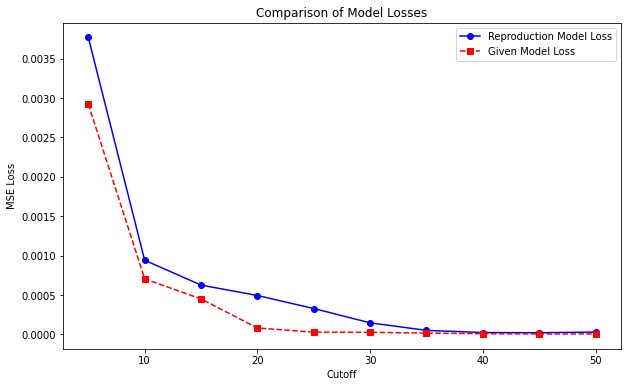

In [30]:

reproduction_cutoffs, reproduction_mse = zip(*sorted(reproduction_exp.cutoff_mse_losses.items()))
given_cutoffs, given_mse = zip(*sorted(given_exp.cutoff_mse_losses.items()))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(reproduction_cutoffs, reproduction_mse, label='Reproduction Model Loss', marker='o', linestyle='-', color='b')
plt.plot(given_cutoffs, given_mse, label='Given Model Loss', marker='s', linestyle='--', color='r')

# Adding titles and labels
plt.title('Comparison of Model Losses')
plt.xlabel('Cutoff')
plt.ylabel('MSE Loss')
plt.grid(False)
plt.legend()

print("Average Inference Times:")
print("Reproduction Model: ", reproduction_exp.avg_time)
print("Given Model: ", given_exp.avg_time)        